In [2]:
import os
import numpy as np
import librosa
import librosa.display
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
from scipy.signal import find_peaks
from random import randrange
import math
import random
import time

# First let's calculate a fingerprint for an audio recording.

In [3]:
soundFiles = []
for entry in os.scandir('database_recordings'):
    if entry.path[-4:] == '.wav':
        soundFiles += [entry.path]
fileName = soundFiles[randrange(len(soundFiles))]
print('Loading', fileName)
snd, sr = librosa.load(fileName)


Loading database_recordings/jazz.00007.wav


Text(0.5, 1.0, 'Mel-frequency spectrogram')

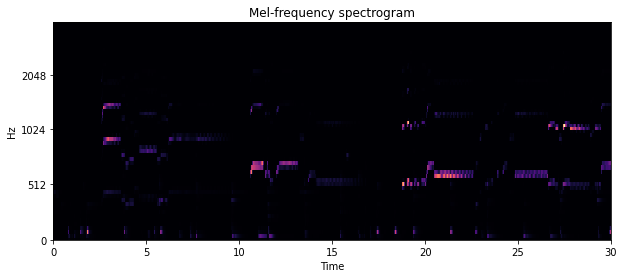

In [4]:
hopLength = 512
n_hashes=64

S = librosa.feature.melspectrogram(snd, sr=sr, hop_length=hopLength, n_mels=n_hashes, fmax=4000)

#Find frequencies of the mel bins I'm using.
mel_freq_bins = librosa.core.mel_frequencies(n_mels=n_hashes, fmax=4000)

#Plot the spectrogram
plt.figure(figsize=(10, 4))

librosa.display.specshow(S, x_axis='time', y_axis='mel', sr=sr, fmax=4000)
plt.title('Mel-frequency spectrogram')

# Peak picking in the spectrogram!

In [5]:
maxPeaksPerSecond=10
lengthOfFile_seconds=len(snd)//sr

#using skimage's peak detection function.
coordinates = peak_local_max(S, min_distance=3, num_peaks=maxPeaksPerSecond*lengthOfFile_seconds)
#sort them by their time step
coordinates = coordinates[np.argsort(coordinates[:, 1])]

Coordinates are of the form: {MelFrequencyBin, TimeStep}

To get to the corresponding frequency, take mel_freq_bins(Coordinate(0))

To get the corresponding time in seconds, take Coordinate(1)*hopLength/SampleRate

# Computes the fingerprint of a given audio file

In [10]:
def computeFingerprint(fileName, params, plotSpectrograms=False):
    """Fingerprint is computed by either (a) finding peaks in the melspectrogram using the inverted list method.
                                         (b) finding pairs of peaks in the melspectrogram.
    """
    snd, sr = librosa.load(fileName)
    lengthOfFile_seconds=len(snd)//sr
    
    #Get all of the variables out of the params
    usePeakPairs = params['usePeakPairs']
    hopLength = params['hopLength']
    nHashes = params['nHashes']
    maxPeaksPerSecond = params['maxPeaksPerSecond']
    fMax = params['fMax']
    fanOut = params['fanOut']
    targetZoneK = params['targetZoneK']
    targetZoneT = params['targetZoneT']
    
    S = librosa.feature.melspectrogram(snd, sr=sr, hop_length=hopLength, n_mels=nHashes, fmax=fMax)

    #using skimage's peak detection function.
    coordinates = peak_local_max(S, min_distance=peakDetectionMinDistance, num_peaks=maxPeaksPerSecond*lengthOfFile_seconds)
    #sort them by their time step
    coordinates = coordinates[np.argsort(coordinates[:, 1])]
    
    if plotSpectrograms:
        #Find frequencies of the mel bins I'm using.
        mel_freq_bins = librosa.core.mel_frequencies(n_mels=n_hashes, fmax=fMax)
        
        S_dB = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(10, 2))
        plt.title('Mel-frequency spectrogram: ' + fileName)
        librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=fMax)
        plt.figure(figsize=(10, 2))
        for coordinate in coordinates:
            plt.plot(coordinate[1]*hopLength/sr, mel_freq_bins[coordinate[0]], 'wo')
        librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=fMax)
    
    hashLists = constructHashLists(coordinates, nHashes, usePeakPairs, fanOut=fanOut, targetZoneK=targetZoneK, targetZoneT=targetZoneT)
    
    return hashLists

def constructHashLists(peakCoordinates, n_hashes, usePeakPairs, fanOut=10, targetZoneK=20, targetZoneT=30):
    """Creates a list for each hash (frequency band) which contains the
    points at which that frequency band has a peak in the audio.
    
    Inputs: peakCoordinates - np array of the form:
            [[hashNumber, timeStep],
            [hashNumber, timeStep]
                      ..
                      ..
            [hashNumber, timeStep]]
            
            n_hashes - the number of hash lists to create.
            
            usePeakPairs (Bool) - defines whether or not to use the inverted list or peak pair methods.
            fanOut, targetZoneK, targetZoneT are used and defined in the peak pair method.
    
    Outputs: hash_lists. Dictionary of the form: {hash_number, hash_list}
                        where hash_number is just a frequency bin number and hash_list is a list of points where that frequency has a peak"""
    
    if usePeakPairs:
        return constructPeakPairHashLists(peakCoordinates, n_hashes, fanOut=fanOut, targetZoneK=targetZoneK, targetZoneT=targetZoneT)
    
    hash_lists = {}
    for hashNum in range(n_hashes):
        hash_list = peakCoordinates[np.nonzero(peakCoordinates[:,0]==hashNum),1]
        if np.size(hash_list)>0:
            hash_lists[hashNum] = hash_list[0]
    
    return hash_lists

def constructPeakPairHashLists(peakCoordinates, n_hashes, fanOut=10, targetZoneK=20, targetZoneT=30):
    """
    For each coordinate in peakCoordinates, find other peaks within a target zone, up to a maximum of fanOut.
    Inputs: peakCoordinates - as defined above
            fanOut - The maximum amount of hashed points to return for each peak
            targetZoneK - Half the target zone frequency size
            targetZoneT - The target zone time size
    Returns: hash_list. Dictionary of the form: {hash_key, time_offset}
                        where hash_key is a tuple of (k1, k2, t_diff)]"""
    hash_list = {}
    
    for peak in peakCoordinates:
        numberOfHashesAddedForThisPeak=0
        for otherPeak in peakCoordinates:
            #Check that it's within the time range of the target zone.
            if peak[1]+5 < otherPeak[1] <= peak[1] + targetZoneT+5:
                #Check that it's within the frequency range of the target zone.
                if peak[0]-targetZoneK <= otherPeak[0] <= peak[0]+targetZoneK:
                    #Found another peak in the target zone! Add it to the hash_list
                    hash_list[(peak[0], otherPeak[0], otherPeak[1]-peak[1])] = peak[1]
                    numberOfHashesAddedForThisPeak += 1
            
            if numberOfHashesAddedForThisPeak >= fanOut:
                #Move on to the next peak in peakCoordinates.
                break
    return hash_list

7


{(35, 24, 6): 7,
 (35, 34, 8): 7,
 (35, 42, 10): 7,
 (35, 47, 14): 7,
 (35, 22, 14): 7,
 (35, 41, 15): 7,
 (35, 42, 22): 7,
 (35, 23, 23): 7,
 (35, 34, 23): 7,
 (35, 47, 27): 7,
 (18, 24, 6): 7,
 (18, 11, 6): 7,
 (18, 34, 8): 883,
 (18, 22, 14): 7,
 (18, 11, 15): 130,
 (18, 23, 23): 7,
 (18, 34, 23): 7,
 (18, 11, 23): 7,
 (18, 4, 29): 7,
 (46, 34, 8): 7,
 (46, 42, 10): 7,
 (46, 47, 14): 7,
 (46, 41, 15): 7,
 (46, 42, 22): 7,
 (46, 34, 23): 7,
 (46, 47, 27): 7,
 (24, 34, 2): 667,
 (24, 42, 4): 13,
 (24, 22, 8): 13,
 (24, 11, 9): 13,
 (24, 41, 9): 1093,
 (24, 42, 16): 906,
 (24, 23, 17): 13,
 (24, 34, 17): 13,
 (24, 11, 17): 13,
 (24, 4, 23): 13,
 (11, 22, 8): 13,
 (11, 11, 9): 13,
 (11, 23, 17): 798,
 (11, 11, 17): 13,
 (11, 4, 23): 905,
 (11, 24, 26): 546,
 (34, 42, 2): 15,
 (34, 47, 6): 15,
 (34, 22, 6): 15,
 (34, 41, 7): 94,
 (34, 42, 14): 15,
 (34, 23, 15): 15,
 (34, 34, 15): 15,
 (34, 47, 19): 15,
 (34, 33, 24): 15,
 (34, 24, 24): 15,
 (42, 47, 4): 17,
 (42, 22, 4): 17,
 (42, 41, 5

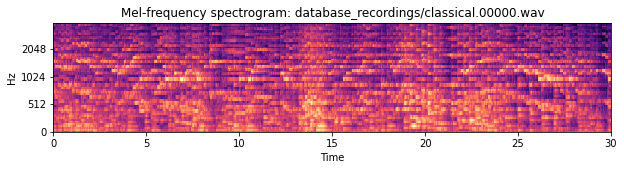

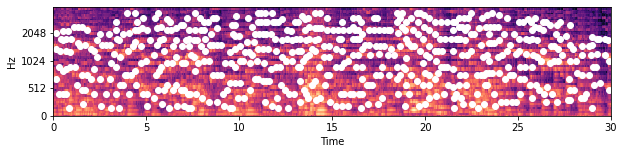

In [7]:
#Test computing a fingerprint
peakDetectionMinDistance=4
fMax=4000
maxPeaksPerSecond=10
nHashes=64
hashList = computeFingerprint('database_recordings/classical.00000.wav', usePeakPairs=True, n_hashes=nHashes, plotSpectrograms=True)

try:
    print(hashList[(35,34,8)])
except KeyError:
    print('Hash not in list, whoopsidaisy')
hashList

In [8]:
#Test saving the hash list.
np.save('database_recordings/classical.00044_print_pairs.npy',hashList)
#Test loading the dictionary
fingerprint = np.load('database_recordings/classical.00044_print_pairs.npy', allow_pickle=True)
#print(fingerprint[()])

# Compute all the fingerprints for the entire dataset

In [12]:
params = {
    'usePeakPairs':True,
    'hopLength':512,
    'nHashes':64,
    'maxPeaksPerSecond':30,
    'fMax':4000,
    'fanOut':10,
    'targetZoneK':6,
    'targetZoneT':30
}

hopLength=512
nHashes=64
maxPeaksPerSecond=20
fMax=4000
peakDetectionMinDistance=4
usePeakPairs = True
targetZoneT = 30
targetZoneK = 20
fanOut = 5

start = time.time()
for entry in os.scandir('database_recordings'):
    if entry.path[-4:] == '.wav':
        #print('Processing', entry.path)
        fingerprint = computeFingerprint(entry.path, usePeakPairs=usePeakPairs, hopLength=hopLength, n_hashes=nHashes,
                                         maxPeaksPerSecond=maxPeaksPerSecond, fMax=fMax, fanOut=fanOut, targetZoneK=targetZoneK, targetZoneT=targetZoneT)
        if usePeakPairs:
            np.save(entry.path[:-4] + '_print_pairs.npy', fingerprint)
        else:
            np.save(entry.path[:-4] + '_print.npy', fingerprint)
        #np.save('database_recordings/fingerprints/classical.00044_fingerprint.npy',hashLists)


end = time.time()
print('Time taken to fingerprint entire dataset:', end - start, 'seconds. That\'s', (end-start)/319, 'seconds per entry.')

Processing database_recordings/jazz.00016.wav
Processing database_recordings/jazz.00002.wav
Processing database_recordings/pop.00027.wav
Processing database_recordings/pop.00033.wav
Processing database_recordings/classical.00079.wav
Processing database_recordings/classical.00045.wav
Processing database_recordings/classical.00051.wav
Processing database_recordings/classical.00086.wav
Processing database_recordings/classical.00092.wav
Processing database_recordings/classical.00093.wav
Processing database_recordings/classical.00087.wav
Processing database_recordings/classical.00050.wav
Processing database_recordings/classical.00044.wav
Processing database_recordings/classical.00078.wav
Processing database_recordings/pop.00032.wav
Processing database_recordings/pop.00026.wav
Processing database_recordings/jazz.00003.wav
Processing database_recordings/jazz.00017.wav
Processing database_recordings/jazz.00001.wav
Processing database_recordings/jazz.00015.wav
Processing database_recordings/jaz

Processing database_recordings/jazz.00069.wav
Processing database_recordings/jazz.00041.wav
Processing database_recordings/jazz.00055.wav
Processing database_recordings/jazz.00043.wav
Processing database_recordings/jazz.00057.wav
Processing database_recordings/jazz.00080.wav
Processing database_recordings/jazz.00094.wav
Processing database_recordings/pop.00072.wav
Processing database_recordings/pop.00066.wav
Processing database_recordings/pop.00099.wav
Processing database_recordings/classical.00038.wav
Processing database_recordings/classical.00010.wav
Processing database_recordings/classical.00004.wav
Processing database_recordings/classical.00005.wav
Processing database_recordings/classical.00011.wav
Processing database_recordings/classical.00039.wav
Processing database_recordings/pop.00098.wav
Processing database_recordings/pop.00067.wav
Processing database_recordings/pop.00073.wav
Processing database_recordings/jazz.00095.wav
Processing database_recordings/jazz.00081.wav
Processing

- Time to create fingerprints for 300 recordings using inverted lists is 27 seconds.
- Time to create fingerprints for 300 recordings using pairs of peaks is 244 seconds with targetZoneK=10, targetZoneT=23, fanOut=10
                                                     
- With improved fingerprint creation using pairs of peaks it's  273 seconds with targetZoneK=20, targetZoneT=10
                                                                110 seconds with targetZoneT=30, targetZoneK=20,fanOut=5
                                                                194 seconds with targetT=30, targetK=6, fanOut=5

In [ ]:
try:
    a[2]
except KeyError:
    print('No hash found')